In [2]:
import pandas as pd
from sqlalchemy import create_engine
import json

# 접속 정보 로딩 (옵션: db-config.json 파일이 있을 경우)
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

# vehicle_reg_stats 테이블 데이터 읽어오기
query4 = "SELECT * FROM vehicle_reg_stats"
vehicle = pd.read_sql(query4, con=engine)

# ▶ 결과 확인
vehicle.head()

,id,datetime,region,fuel_type,use_type,reg_count
0,1,2017-01-01,강원,경유,사업용,12362.0
1,2,2017-01-01,광주,전기,비사업용,240.0
2,3,2017-01-01,인천,전기,사업용,6.0
3,4,2017-01-01,인천,전기,비사업용,210.0
4,5,2017-01-01,대구,전기,사업용,53.0


In [3]:
# 사업용 디젤 차량 데이터
diesel_business = vehicle[(vehicle['fuel_type'] == '경유') & (vehicle['use_type'] == '사업용')].copy()

# 전기차 - 사업용
ev_business = vehicle[(vehicle['fuel_type'] == '전기') & (vehicle['use_type'] == '사업용')].copy()

# 전기차 - 비사업용
ev_nonbusiness = vehicle[(vehicle['fuel_type'] == '전기') & (vehicle['use_type'] == '비사업용')].copy()

In [4]:
print(vehicle['fuel_type'].dropna().unique())
print(vehicle['use_type'].dropna().unique())

['경유' '전기' '휘발유']
['사업용' '비사업용']


In [5]:
# vehicle 원본에서 바로 분기
vehicle_raw = pd.read_sql("SELECT * FROM vehicle_reg_stats", con=engine)
vehicle_raw['datetime'] = pd.to_datetime(vehicle_raw['datetime'], errors='coerce')

# 1. 서울만 필터링 (2018년까지)
vehicle_pre_2019 = vehicle_raw[(vehicle_raw['datetime'] <= '2018-12-31') & (vehicle_raw['region'] == '서울')].copy()

# 2. 2019년 1월 데이터 중 구별 연료 비율 구하기
vehicle_over_2019 = vehicle_raw[vehicle_raw['datetime'] >= '2019-01-01'].copy()
base = vehicle_over_2019[vehicle_over_2019['datetime'] == '2019-01-01']
base_ratio = base.groupby(['region', 'fuel_type'])['reg_count'].sum()
base_ratio = base_ratio / base_ratio.groupby('fuel_type').transform('sum')
base_ratio = base_ratio.reset_index().rename(columns={'reg_count': 'ratio'})

# 3. 서울 데이터를 각 구별로 비율 분배
vehicle_pre_2019['fuel_type'] = vehicle_pre_2019['fuel_type'].str.strip()
base_ratio['fuel_type'] = base_ratio['fuel_type'].str.strip()
vehicle_expanded = pd.merge(vehicle_pre_2019, base_ratio, on='fuel_type', how='left')
vehicle_expanded['reg_count'] *= vehicle_expanded['ratio']
vehicle_expanded['region'] = vehicle_expanded['region_y']
vehicle_expanded = vehicle_expanded[['datetime', 'region', 'fuel_type', 'reg_count', 'use_type']]

# 4. 병합 전 데이터로 vehicle 재생성
vehicle = pd.concat([vehicle_expanded, vehicle_over_2019], ignore_index=True)

In [6]:
print(vehicle['fuel_type'].dropna().unique())

['전기' '경유' '휘발유']


In [7]:
# 디젤 사업용 필터링
diesel_business = vehicle[
    (vehicle['fuel_type'] == '경유') & 
    (vehicle['use_type'] == '사업용')
].copy()

# 전기차 전체 (사업용 + 비사업용)
ev_total = vehicle[
    (vehicle['fuel_type'] == '전기')
].copy()


In [8]:
# 그룹화 함수
def get_monthly_sum(df, label):
    df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()
    df_grouped['type'] = label
    return df_grouped

diesel_monthly = get_monthly_sum(diesel_business, '디젤_사업용')
ev_monthly = get_monthly_sum(ev_total, '전기차_전체')

C:\Users\USER\AppData\Local\Temp\ipykernel_18368\2181948457.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_18368\2181948457.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [10]:
# 2021년 12월 이후 데이터로 필터링
diesel_monthly_filtered = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01']
ev_monthly_filtered = ev_monthly[ev_monthly['datetime'] >= '2021-12-01']

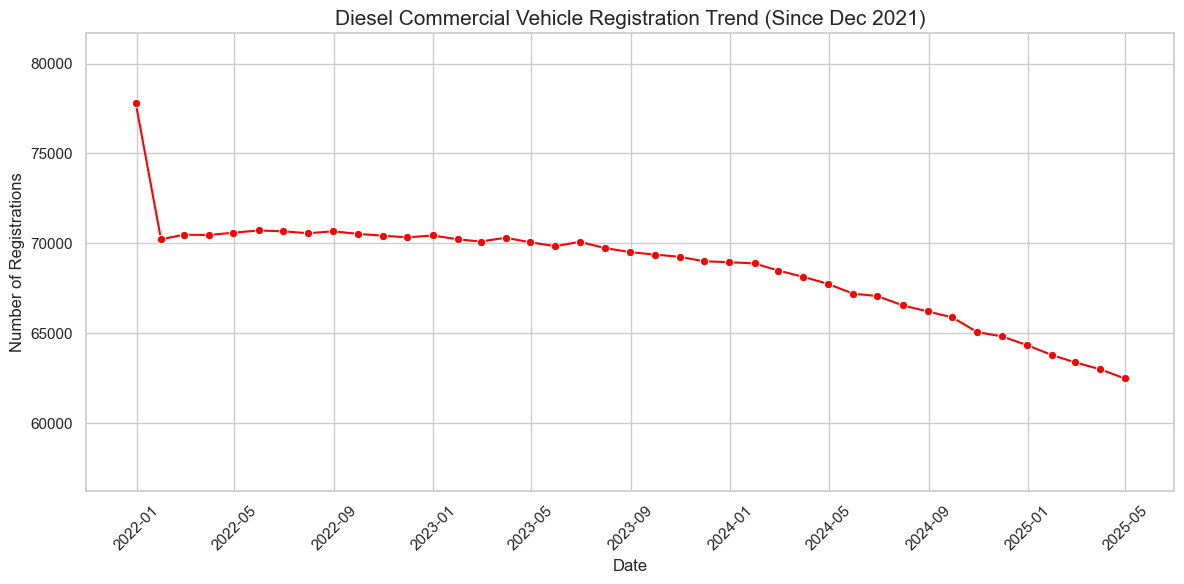

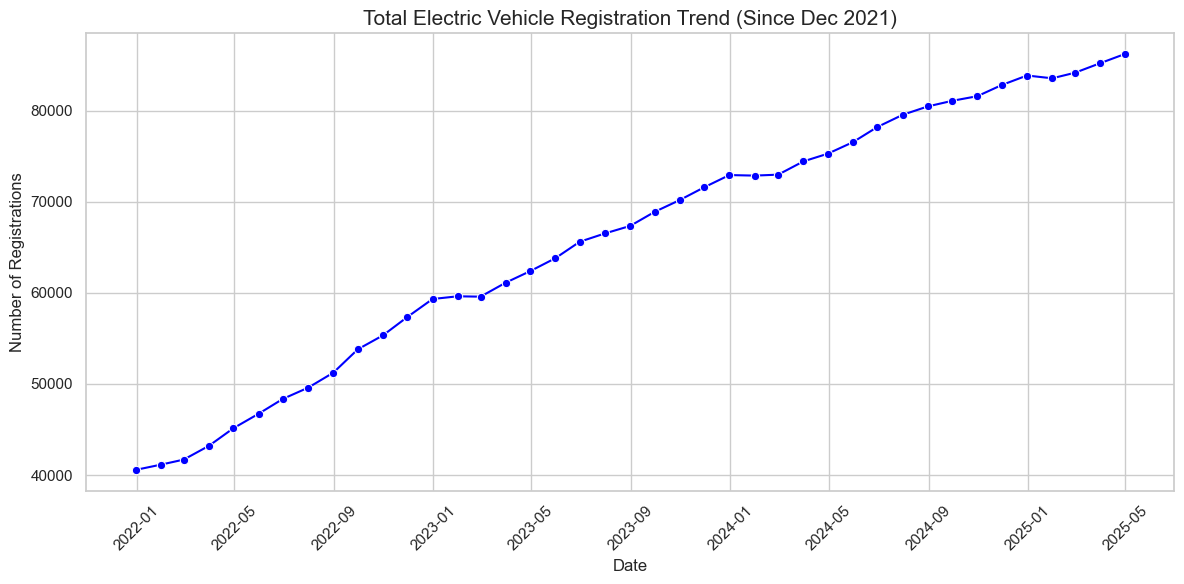

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 스타일
sns.set(style='whitegrid')

# 데이터 필터링 (2021년 12월 이후)
diesel_filtered = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01']
ev_filtered = ev_monthly[ev_monthly['datetime'] >= '2021-12-01']

# 1. 디젤 사업용 그래프 (스케일 강조)
plt.figure(figsize=(12, 6))
sns.lineplot(data=diesel_filtered, x='datetime', y='reg_count', color='red', marker='o')
plt.title('Diesel Commercial Vehicle Registration Trend (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)

# y축 최대값 조정 (디젤 변화 강조)
plt.ylim(diesel_filtered['reg_count'].min() * 0.9,
         diesel_filtered['reg_count'].max() * 1.05)

plt.tight_layout()
plt.show()

# 2. 전기차 전체 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(data=ev_filtered, x='datetime', y='reg_count', color='blue', marker='o')
plt.title('Total Electric Vehicle Registration Trend (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


08:59:15 - cmdstanpy - INFO - Chain [1] start processing
08:59:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


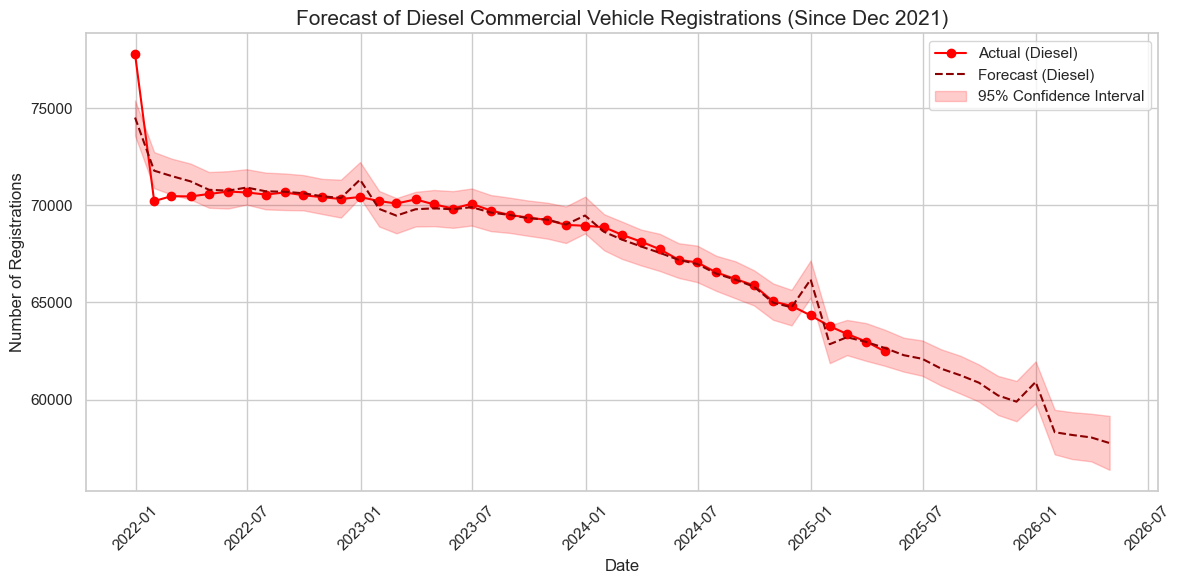

08:59:16 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


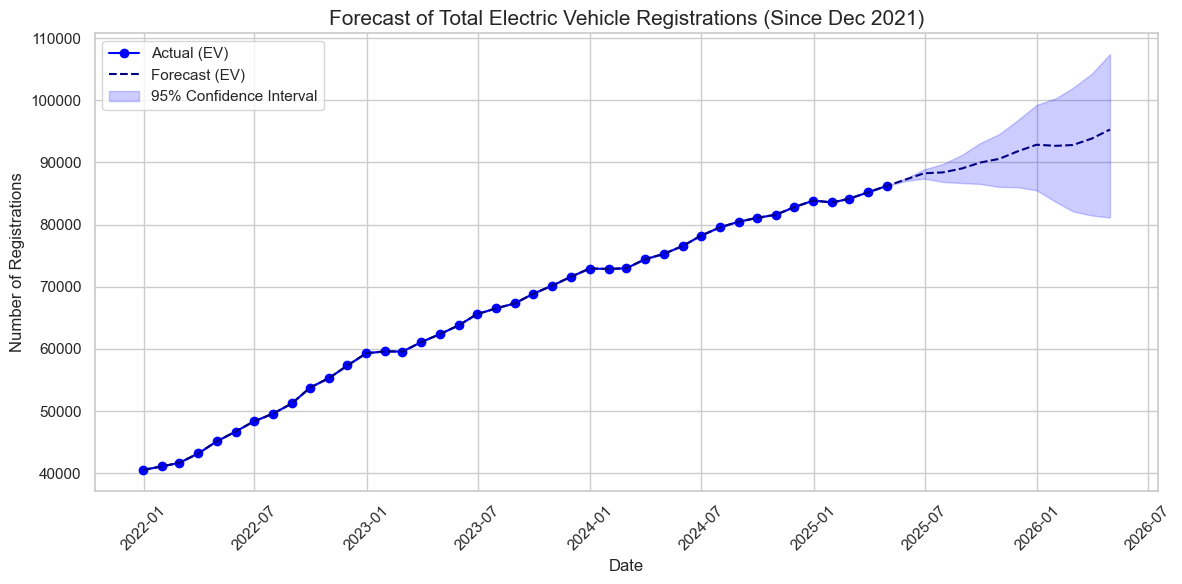

In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# 1. Diesel Commercial Vehicles (from Dec 2021)
diesel_df = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01'].copy()
diesel_df = diesel_df.rename(columns={'datetime': 'ds', 'reg_count': 'y'})

diesel_model = Prophet()
diesel_model.fit(diesel_df)

diesel_future = diesel_model.make_future_dataframe(periods=12, freq='M')
diesel_forecast = diesel_model.predict(diesel_future)

# ▶ Plot: Diesel Vehicles
plt.figure(figsize=(12, 6))
plt.plot(diesel_df['ds'], diesel_df['y'], label='Actual (Diesel)', marker='o', color='red')
plt.plot(diesel_forecast['ds'], diesel_forecast['yhat'], label='Forecast (Diesel)', linestyle='--', color='darkred')
plt.fill_between(diesel_forecast['ds'], diesel_forecast['yhat_lower'], diesel_forecast['yhat_upper'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Forecast of Diesel Commercial Vehicle Registrations (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. Electric Vehicles (from Dec 2021)
ev_df = ev_monthly[ev_monthly['datetime'] >= '2021-12-01'].copy()
ev_df = ev_df.rename(columns={'datetime': 'ds', 'reg_count': 'y'})

ev_model = Prophet()
ev_model.fit(ev_df)

ev_future = ev_model.make_future_dataframe(periods=12, freq='M')
ev_forecast = ev_model.predict(ev_future)

# ▶ Plot: Electric Vehicles
plt.figure(figsize=(12, 6))
plt.plot(ev_df['ds'], ev_df['y'], label='Actual (EV)', marker='o', color='blue')
plt.plot(ev_forecast['ds'], ev_forecast['yhat'], label='Forecast (EV)', linestyle='--', color='navy')
plt.fill_between(ev_forecast['ds'], ev_forecast['yhat_lower'], ev_forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Forecast of Total Electric Vehicle Registrations (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

c:\ex\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\ex\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\ex\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\ex\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ex\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

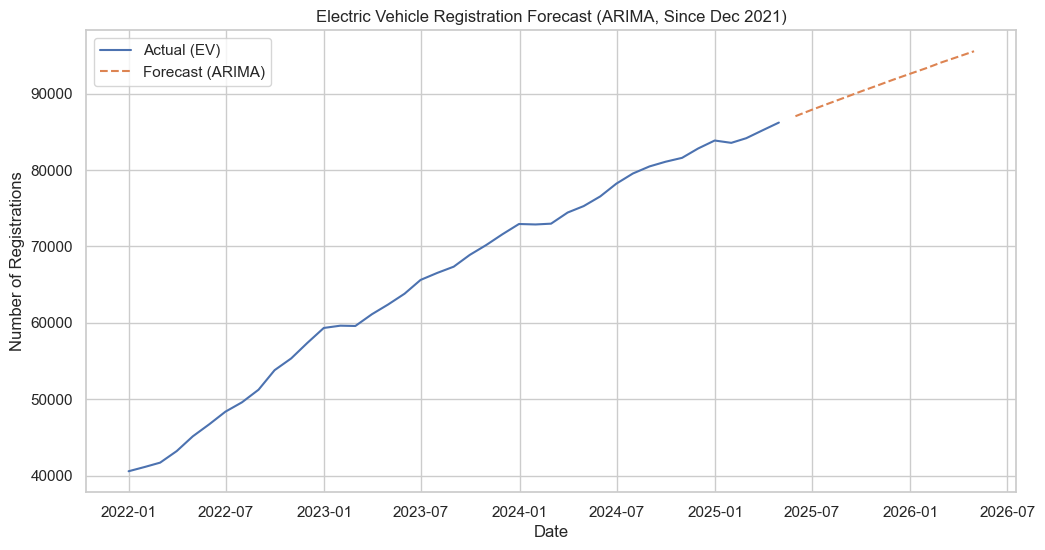

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 데이터 준비 (예: 전기차 월별 등록수)
df = ev_monthly[ev_monthly['datetime'] >= '2021-12-01'].copy()
df.set_index('datetime', inplace=True)
ts = df['reg_count']

# ARIMA 모델 학습 (p,d,q) 값은 데이터에 맞게 조정 필요 (여기선 예시로 (2,1,2))
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()

# 향후 12개월 예측
forecast = model_fit.forecast(steps=12)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label='Actual (EV)')
plt.plot(forecast.index, forecast, label='Forecast (ARIMA)', linestyle='--')
plt.title('Electric Vehicle Registration Forecast (ARIMA, Since Dec 2021)')
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_18368\1285463075.py:45: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\ex\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


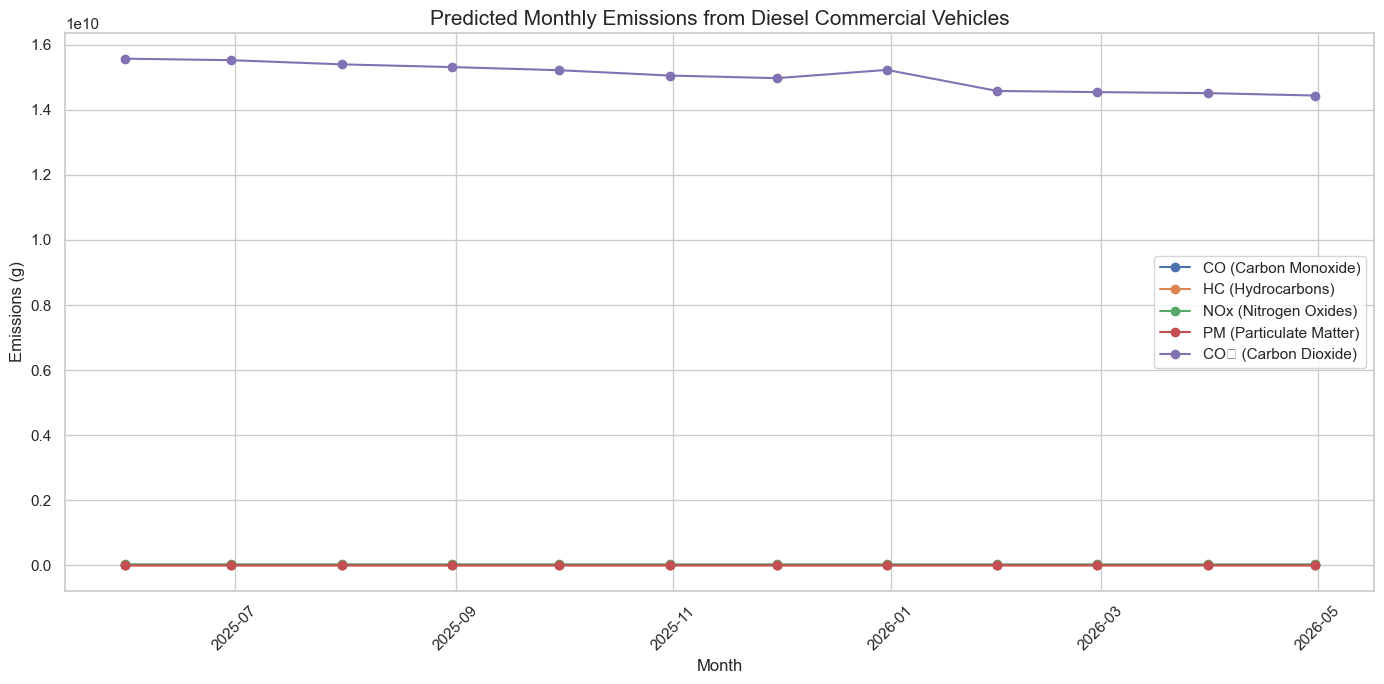

C:\Users\USER\AppData\Local\Temp\ipykernel_18368\1285463075.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


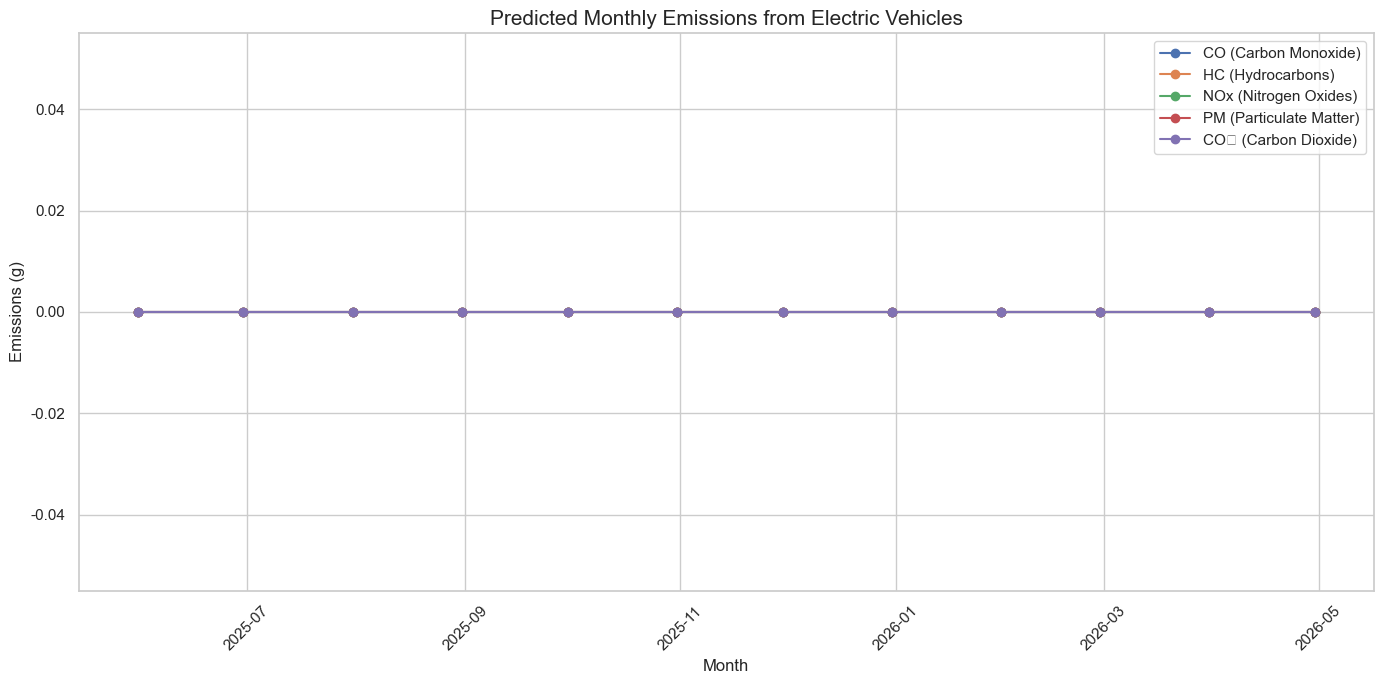

In [17]:
import matplotlib.pyplot as plt

# 1. 오염물질별 배출계수 (예시, 실제 값으로 교체 가능)
EMISSION_FACTORS = {
    'diesel': {
        'CO': 2500,     # g/대/년
        'HC': 200,      # g/대/년
        'NOx': 6000,    # g/대/년
        'PM': 80,       # g/대/년
        'CO2': 3000*1000 # g/대/년 (3,000kg -> g)
    },
    'ev': {
        'CO': 0,
        'HC': 0,
        'NOx': 0,
        'PM': 0,
        'CO2': 0
    }
}

# 2. 오염물질별 배출량 계산 함수
def calc_emissions_multi(df, factor):
    for pol in ['CO', 'HC', 'NOx', 'PM', 'CO2']:
        # 월별 배출량 = (연간 배출계수 / 12) * 등록대수
        df[pol] = (EMISSION_FACTORS[factor][pol] / 12) * df['yhat']
    return df[['ds', 'CO', 'HC', 'NOx', 'PM', 'CO2']]

# 3. 예측 데이터로 배출량 산출
diesel_emissions = calc_emissions_multi(diesel_pred.copy(), 'diesel')
ev_emissions = calc_emissions_multi(ev_pred.copy(), 'ev')

# 4. 그래프 1: 디젤 사업용 차량 예측 + 오염물질 추세
plt.figure(figsize=(14, 7))
plt.plot(diesel_emissions['ds'], diesel_emissions['CO'], label='CO (Carbon Monoxide)', marker='o')
plt.plot(diesel_emissions['ds'], diesel_emissions['HC'], label='HC (Hydrocarbons)', marker='o')
plt.plot(diesel_emissions['ds'], diesel_emissions['NOx'], label='NOx (Nitrogen Oxides)', marker='o')
plt.plot(diesel_emissions['ds'], diesel_emissions['PM'], label='PM (Particulate Matter)', marker='o')
plt.plot(diesel_emissions['ds'], diesel_emissions['CO2'], label='CO₂ (Carbon Dioxide)', marker='o')
plt.title('Predicted Monthly Emissions from Diesel Commercial Vehicles', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Emissions (g)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. 그래프 2: 전기차 예측 + 오염물질 추세
plt.figure(figsize=(14, 7))
plt.plot(ev_emissions['ds'], ev_emissions['CO'], label='CO (Carbon Monoxide)', marker='o')
plt.plot(ev_emissions['ds'], ev_emissions['HC'], label='HC (Hydrocarbons)', marker='o')
plt.plot(ev_emissions['ds'], ev_emissions['NOx'], label='NOx (Nitrogen Oxides)', marker='o')
plt.plot(ev_emissions['ds'], ev_emissions['PM'], label='PM (Particulate Matter)', marker='o')
plt.plot(ev_emissions['ds'], ev_emissions['CO2'], label='CO₂ (Carbon Dioxide)', marker='o')
plt.title('Predicted Monthly Emissions from Electric Vehicles', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Emissions (g)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['CO'], label='CO (Carbon Monoxide)', marker='o')
plt.plot(df['ds'], df['HC'], label='HC (Hydrocarbons)', marker='o')
plt.plot(df['ds'], df['NOx'], label='NOx (Nitrogen Oxides)', marker='o')
plt.plot(df['ds'], df['PM'], label='PM (Particulate Matter)', marker='o')
plt.plot(df['ds'], df['CO2'], label='CO₂ (Carbon Dioxide)', marker='o')
plt.title('Predicted Monthly Emissions from Diesel Commercial Vehicles', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Emissions (g)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'ds'

<Figure size 1400x700 with 0 Axes>

In [13]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------ --------------------------------- 2.1/13.3 MB 10.7 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/13.3 MB 10.8 MB/s eta 0:00:01
   ------------------ --------------------- 6.0/13.3 MB 10.0 MB/s eta 0:00:01
   ------------------------ --------------- 8.1/13.3 MB 10.3 MB/s eta 0:00:01
   ------------------------------- -------- 10.5/13.3 MB 10.2 MB/s eta 0:00:01
   ------------------------------------- -- 12.6/13.3 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
